**Import Libraries and Settings**

In [1]:
!pip install -qq transformers

In [2]:
import requests
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**Dataset Import, Analysis and Adaptation**

In [5]:
url = "https://raw.githubusercontent.com/cp9321/Sentiment-Analysis-BERT/main/reviewsunders.csv"

In [6]:
df = pd.read_csv(url)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [7]:
print(df.shape)
df.info()

(12495, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12495 non-null  object
 1   userName              12495 non-null  object
 2   userImage             12495 non-null  object
 3   content               12495 non-null  object
 4   score                 12495 non-null  int64 
 5   thumbsUpCount         12495 non-null  int64 
 6   reviewCreatedVersion  10333 non-null  object
 7   at                    12495 non-null  object
 8   replyContent          5818 non-null   object
 9   repliedAt             5818 non-null   object
 10  sortOrder             12495 non-null  object
 11  appId                 12495 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


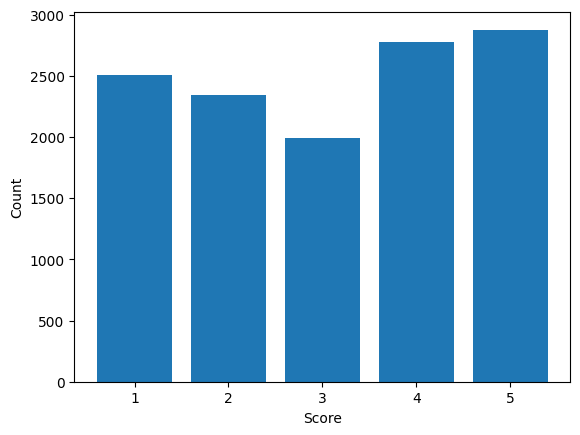

In [8]:
counts = df["score"].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel('Score');
plt.ylabel('Count');
plt.show()

In [9]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

class_names = ['Negative', 'Neutral', 'Positive']

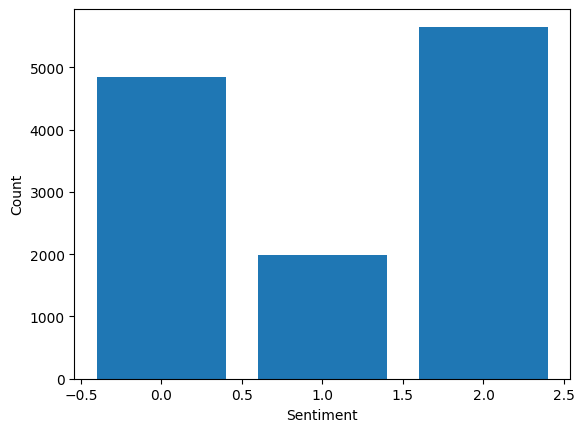

In [10]:
counts = df["sentiment"].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel('Sentiment');
plt.ylabel('Count');
plt.show()

**Tokenization, Split and Data Loader creation**

In [11]:
PRE_TRAINED_MODEL = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


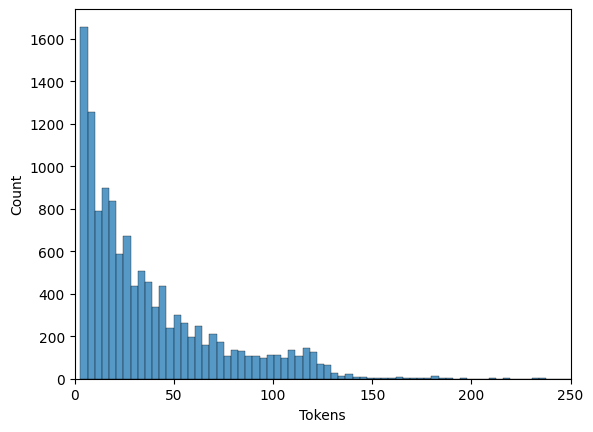

In [12]:
lengths = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  lengths.append(len(tokens))

sns.histplot(lengths)
plt.xlim([0, 250]);
plt.xlabel('Tokens');

In [13]:
MAX_LEN = 165

In [14]:
class ReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      padding='max_length',
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [15]:
df_train, dftest = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(dftest, test_size=0.5, random_state=RANDOM_SEED)

In [16]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(11245, 13)
(625, 13)
(625, 13)


In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )


In [18]:
BATCH_SIZE = 16

In [19]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**BERT model and training**

In [20]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [21]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [22]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [23]:
data = next(iter(train_data_loader))
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [24]:
EPOCHS = 7

In [25]:
optimizer = AdamW(model.parameters(), lr=15e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return (correct_predictions.double() / n_examples), np.mean(losses)

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return (correct_predictions.double() / n_examples), np.mean(losses)

In [28]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('- ' * 20)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

Epoch 1/7
- - - - - - - - - - - - - - - - - - - - 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.6577936531300226 accuracy 0.7421965317919076
Val   loss 0.6277508921921253 accuracy 0.7664000000000001

Epoch 2/7
- - - - - - - - - - - - - - - - - - - - 
Train loss 0.4795631072291863 accuracy 0.8140506891951979
Val   loss 0.6948375558480621 accuracy 0.7536

Epoch 3/7
- - - - - - - - - - - - - - - - - - - - 
Train loss 0.35313107132657323 accuracy 0.8719430858159182
Val   loss 0.777694889344275 accuracy 0.7488

Epoch 4/7
- - - - - - - - - - - - - - - - - - - - 
Train loss 0.25839631756235065 accuracy 0.9126722987994664
Val   loss 1.0274841031059623 accuracy 0.7392000000000001

Epoch 5/7
- - - - - - - - - - - - - - - - - - - - 
Train loss 0.19908848387198483 accuracy 0.938728323699422
Val   loss 1.2699537456035614 accuracy 0.7424000000000001

Epoch 6/7
- - - - - - - - - - - - - - - - - - - - 
Train loss 0.15798445254717297 accuracy 0.9557136505113384
Val   loss 1.3904349394142628 accuracy 0.7312000000000001

Epoch 7/7
- - - - - - - - - - - - - - - - - - - - 
Train loss 0.1

**Evaluating and predicting**

In [29]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print(test_acc.item())

0.728


In [30]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [31]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [32]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.77      0.76      0.77       242
     Neutral       0.41      0.41      0.41       125
    Positive       0.83      0.85      0.84       258

    accuracy                           0.73       625
   macro avg       0.67      0.67      0.67       625
weighted avg       0.73      0.73      0.73       625



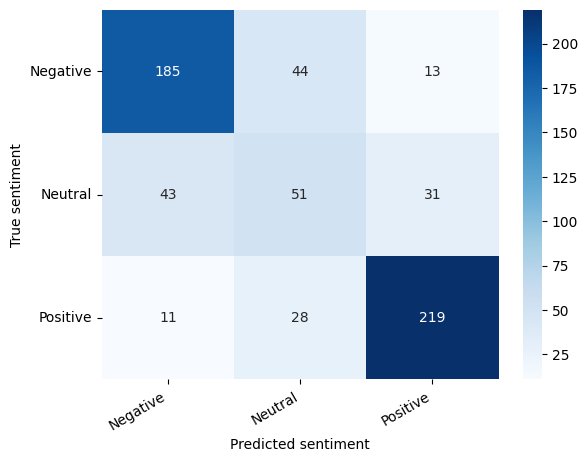

In [33]:
def print_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
print_confusion_matrix(df_cm)

In [34]:
review_text = "One of the worst exerience of my life. This app is awful!"

In [35]:
encoded_review = tokenizer.encode_plus(
  review_text,
  padding='max_length',
  truncation=True,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: One of the worst exerience of my life. This app is awful!
Sentiment  : Negative
